In [ ]:
! nvidia-smi
! python --version
! which python
! python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [3]:
import warnings

warnings.filterwarnings('ignore')

# from tensorflow.compat.v1.keras.backend import get_session
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.compat.v1.disable_v2_behavior()  # breaks

2024-03-08 12:39:52.684948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 12:39:53.423567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  2
Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [7]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # second gpu

In [5]:
# gpu_to_limit = gpus[int(os.environ["CUDA_VISIBLE_DEVICES"])]
gpu_to_limit = gpus[1]
gpu_mem_mb = 24564  # all we have
tf.config.set_logical_device_configuration(
    gpu_to_limit, [tf.config.LogicalDeviceConfiguration(memory_limit=gpu_mem_mb // 4)]
)

In [7]:
import numpy

# numpy = reload(numpy)
print(numpy.__version__)

import numpy as np

np.int = int  # Fix deprecated for LUX

1.26.3


In [14]:
# ! conda install -y  seaborn anchor-exp dill
# pip install gower imblearn # TODO in console

from lux.lux.lux import LUX

In [15]:
! if[-f parallel_explainers.py]; then rm parallel_explainers.py; fi
! wget --no-cache --no-cookies -O parallel_explainers.py https://raw.githubusercontent.com/mozo64/xai-evaluation-classes/main/parallel_explainers.py

! tail parallel_explainers.py

from importlib import reload

import parallel_explainers

parallel_explainers.py = reload(parallel_explainers)

from parallel_explainers import (
    compute_generic_explanation_parallel, worker_init_model,
    worker_init_lime, compute_single_lime_explanation,
    compute_lime_explanation, compute_lime_explanation_parallel,
    compute_anchor_explanation,
    compute_single_anchor_explanation,
    ModelWrapper)

/bin/bash: -c: line 1: syntax error near unexpected token `then'
/bin/bash: -c: line 1: ` if[-f parallel_explainers.py]; then rm parallel_explainers.py; fi'
--2024-03-08 12:50:45--  https://raw.githubusercontent.com/mozo64/xai-evaluation-classes/main/parallel_explainers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16662 (16K) [text/plain]
Saving to: ‘parallel_explainers.py’

parallel_explainers 100%[===================>]  16.27K  --.-KB/s    in 0.003s  

2024-03-08 12:50:45 (6.00 MB/s) - ‘parallel_explainers.py’ saved [16662/16662]

    """
    global explainer
    explainer = anchor_tabular.AnchorTabularExplainer(
        train_data=flattened_background_data,
        feature_names=flattened_feature_names,
        class_names=[0, 1],
    )
    print("e

In [16]:
import dill
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import shap

from anchor import anchor_tabular
from collections import deque
from joblib import load
from keras.utils import to_categorical
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import traceback
from typing import Any, List, Optional, Tuple

if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)

DATA_DIRECTORY = "shared/metropt/"

In [11]:
# @formatter:off
! ls shared
# @formatter:on

 comparison.svg					       shared-metro.zip
 convlstm-metropt.ipynb				       summaryMultivariate.csv
 dtw-vs-no-dtw					       summaryUnivariate.csv
 gpu_users.sh					       szymon-env-3.8.yml
'Keras LSTM for IMDB Sentiment Classification.ipynb'   tsproto
 metropt					       Untitled1.ipynb
 proto.tar.gz					       Untitled2.ipynb
 ProtoTSNet					       Untitled.ipynb
 README.txt					       windowshap


In [10]:
%cd shared
from tsproto.windowshap import SlidingWindowSHAP
%cd ..

/home/jovyan/shared
/home/jovyan


In [36]:
def exponential_smoothing(series, alpha):
    """
    Perform exponential smoothing on a pandas Series.

    Parameters:
    series (pd.Series): Input time series as a pandas Series.
    alpha (float): Smoothing parameter (0 < alpha < 1).

    Returns:
    pd.Series: Exponentially smoothed time series.
    """
    smoothed_values = [series.iloc[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)

    return pd.Series(smoothed_values, index=series.index)


def save_to_pickle(obj, filename, directory=DATA_DIRECTORY):
    """
    Save an object to a pickle file.

    Parameters:
    - obj: Object to save
    - filename: Name of the pickle file
    - directory: Directory to save the pickle file (default is DATA_DIRECTORY)

    Returns:
    - None
    """
    filepath = os.path.join(directory, filename)

    # Check if the object is a pandas DataFrame
    if isinstance(obj, pd.DataFrame):
        obj.to_pickle(filepath)
    else:
        with open(filepath, 'wb') as f:
            pickle.dump(obj, f)

    print(f"Saved to {filepath}")


def load_from_pickle(filename, directory=DATA_DIRECTORY):
    """
    Load an object from a pickle file using pandas, pickle, or joblib as a fallback.

    Parameters:
    - filename: Name of the pickle file
    - directory: Directory where the pickle file is located (default is DATA_DIRECTORY)

    Returns:
    - Object loaded from the pickle file
    """
    filepath = os.path.join(directory, filename)

    try:
        import pandas as pd
        obj = pd.read_pickle(filepath)
    except Exception as e:  # Catch any exception from pandas
        print(f"Failed to load pickle with pandas due to: {e}")
        try:
            with open(filepath, 'rb') as f:
                obj = pickle.load(f)
        except Exception as e:  # Catch any exception from standard pickle
            print(f"Failed to load pickle with standard pickle due to: {e}")
            try:
                obj = load(filepath)  # Try with joblib
            except Exception as e:
                print(f"Failed to load pickle with joblib due to: {e}")
                try:
                    obj = dill.load(filepath)  # Try with joblib
                except Exception as e:
                    print(f"Failed to load pickle with dill due to: {e}")

                    raise e  # Re-raise the exception if all methods fail

    return obj


def calculate_threshold_err_cumalert(df: pd.DataFrame) -> None:
    df_cp = df.copy()
    df_cp.loc[:, "threshold_err"] = 0
    df_cp.loc[:, "alert"] = 0
    df_cp.loc[:, "cumalert"] = 0
    bufflen = int(2 * 24 * 7)  #sampels_per_hour * 24 * days
    buffer = deque(maxlen=bufflen)
    abufflen = int(2 * 4)  #samples_per_hour * monitoring_hours
    alertbuf = deque(maxlen=abufflen)
    for i, r in df_cp.iterrows():
        if len(buffer) < bufflen:
            buffer.append(r['err'])
            continue
        avg = np.mean(buffer)
        sigma = np.std(buffer)
        if r['err'] > avg + 3 * sigma:
            df_cp.loc[i, 'alert'] = 1
            alertbuf.append(1)
        else:
            alertbuf.append(0)
            buffer.append(r['err'])
        df_cp.loc[i, 'cumalert'] = sum(alertbuf)

        if sum(alertbuf) >= 0.75 * abufflen:
            df_cp.loc[i, 'alert'] = 40
        else:
            df_cp.loc[i, 'alert'] = 0
        df_cp.loc[i, "threshold_err"] = avg + 3 * sigma

    return df_cp


def calculate_shap_values(fXtrain: np.ndarray,
                          fXtest: np.ndarray,
                          ftrainy: np.ndarray,
                          ftesty: np.ndarray,
                          model_classifier: Any,
                          stride: int,
                          window_len: int,
                          shap_version: str = 'deep',
                          bg_size: int = 1000,
                          absshap: bool = True,
                          background_data: Optional = None,
                          ) -> Tuple[
    Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Calculates SHAP values for training and testing datasets using either DeepExplainer or SlidingWindowSHAP.
    
    :param fXtrain: Training features.
    :param fXtest: Testing features.
    :param ftrainy: Training labels.
    :param ftesty: Testing labels.
    :param model_classifier: The model to explain.
    :param stride: Stride for sliding window SHAP.
    :param window_len: Window length for sliding window SHAP.
    :param shap_version: 'deep' for DeepExplainer, 'window' for SlidingWindowSHAP.
    :param bg_size: Background dataset size for explanations.
    :param absshap: Whether to use absolute SHAP values, only for DeepExplainer.
    :return: Tuple of SHAP values for training and testing datasets.
    """
    if background_data is None:
        indexes = np.arange(len(fXtrain))
        np.random.shuffle(indexes)
        maxid = min(bg_size, len(fXtrain))
        background_data = fXtrain[indexes[:maxid]]

    sv_ts, sv_tr, shap_values_ts, shap_values_tr = None, None, None, None
    if shap_version == 'window':
        # Handle window-based SHAP
        sv_ts = np.zeros((len(fXtest), fXtest.shape[1], fXtest.shape[2]))
        sv_tr = np.zeros((len(fXtrain), fXtrain.shape[1], fXtrain.shape[2]))

        # Calculate for test data
        for i in range(len(fXtest)):
            gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtest[i:i + 1],
                                    model_type='lstm')
            sv_ts[i, :, :] = gtw.shap_values(num_output=ftesty.shape[1])
        # Calculate for train data
        for i in range(len(fXtrain)):
            gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtrain[i:i + 1],
                                    model_type='lstm')
            sv_tr[i, :, :] = gtw.shap_values(num_output=ftrainy.shape[1])

    elif shap_version == 'deep':
        # Handle deep SHAP
        explainer = shap.DeepExplainer(model_classifier, background_data)
        shap_values_ts = explainer.shap_values(fXtest, check_additivity=False)
        shap_values_tr = explainer.shap_values(fXtrain, check_additivity=False)

        if absshap:
            sv_ts = abs(np.array(shap_values_ts)).mean(axis=0)
            sv_tr = abs(np.array(shap_values_tr)).mean(axis=0)
        else:
            indexer_ts = np.argmax(model_classifier.predict(fXtest), axis=1)
            sv_ts = [shap_values_ts[indexer_ts[i]][i, :] for i in range(len(fXtest))]
            sv_ts = np.concatenate(sv_ts).reshape((-1, 30, 16))

            indexer_tr = np.argmax(model_classifier.predict(fXtrain), axis=1)
            sv_tr = [shap_values_tr[indexer_tr[i]][i, :] for i in range(len(fXtrain))]
            sv_tr = np.concatenate(sv_tr).reshape((-1, 30, 16))

    return sv_ts, sv_tr, shap_values_ts, shap_values_tr


def visualize_explanation_difference(sv_tr_absshap: np.ndarray,
                                     sv_tr_v9_seq: np.ndarray,
                                     window_indexes: List[int]) -> None:
    """
    Visualizes the normalized difference between two sets of explanations and plots the average explanations and average difference.

    :param sv_tr_absshap: Numpy array of explanations set 1.
    :param sv_tr_v9_seq: Numpy array of explanations set 2.
    :param window_indexes: List of sample indexes to visualize.
    """
    # Calculate the difference between the two explanation sets
    difference = np.abs(sv_tr_absshap - sv_tr_v9_seq)

    total_difference = np.sum(difference)
    print("Total difference:", total_difference)

    mse = mean_squared_error(sv_tr_absshap.reshape(-1), sv_tr_v9_seq.reshape(-1))
    print("MSE:", mse)

    max_difference = np.max(difference)
    mean_difference = np.mean(difference)
    print("Maximum difference:", max_difference)
    print("Mean difference:", mean_difference)

    # Normalize the difference to range [0, 1]
    normalized_difference = (difference - np.min(difference)) / (np.max(difference) - np.min(difference))

    # Plot average explanations for both sets and average difference
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(np.mean(sv_tr_absshap, axis=0), cmap='viridis', aspect='auto')
    plt.colorbar(label='Average explanations set 1')
    plt.title('Average explanations set 1')
    plt.xlabel('Feature')
    plt.ylabel('Time step')

    plt.subplot(1, 3, 2)
    plt.imshow(np.mean(sv_tr_v9_seq, axis=0), cmap='viridis', aspect='auto')
    plt.colorbar(label='Average explanations set 2')
    plt.title('Average explanations set 2')
    plt.xlabel('Feature')
    plt.ylabel('Time step')

    plt.subplot(1, 3, 3)
    plt.imshow(np.mean(normalized_difference, axis=0), cmap='viridis', aspect='auto')
    plt.colorbar(label='Average normalized difference')
    plt.title('Average normalized difference')
    plt.xlabel('Feature')
    plt.ylabel('Time step')
    plt.tight_layout()
    plt.show()

    # Visualize the normalized difference for selected sample indexes
    for sample_index in window_indexes:
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized_difference[sample_index], cmap='viridis', aspect='auto')
        plt.colorbar(label='Normalized difference')
        plt.title(f'Heatmap of normalized differences, sample {sample_index}')
        plt.xlabel('Feature')
        plt.ylabel('Time step')
        plt.show()



# data

In [14]:
# @formatter:off
! ls shared/metropt
# @formatter:on

dataset_train.csv		  model_lstmconv_encoder_v5_seq.h5
lime_values_tr_absshap.pkl	  model_lstmconv_encoder_v6_fun.h5
lime_values_tr_no_absshap.pkl	  model_lstmconv_encoder_v7_seq.h5
lime_values_ts_absshap.pkl	  model_lstmconv_encoder_v8_fun.h5
lime_values_ts_no_absshap.pkl	  model_lstmconv_encoder_v9_seq.h5
lv_tr_absshap.pkl		  shap_values_tr_absshap.pkl
lv_tr_no_absshap.pkl		  shap_values_tr_no_absshap.pkl
lv_ts_absshap.pkl		  shap_values_tr.pkl
lv_ts_no_absshap.pkl		  shap_values_tr_v8_fun.pkl
model_classifier_v3_fun.h5	  shap_values_tr_v9_seq.pkl
model_classifier_v7_fun.h5	  shap_values_ts_absshap.pkl
model_classifier_v8_fun.h5	  shap_values_ts_no_absshap.pkl
model_classifier_v8_seq.h5	  shap_values_ts.pkl
model_classifier_v9_seq.h5	  shap_values_ts_v8_fun.pkl
model_lstmconv_ae_fun.h5	  shap_values_ts_v9_seq.pkl
model_lstmconv_ae_v2_fun.h5	  sv_tr_absshap.pkl
model_lstmconv_ae_v3_fun.h5	  sv_tr_absshap_true_v8_fun.pkl
model_lstmconv_ae_v4_fun.h5	  sv_tr_absshap_true_v9_seq.pkl
model_

In [18]:
metro_o = pd.read_csv('shared/metropt/dataset_train.csv')
features_o = [f for f in metro_o.columns if f not in ['gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
metro_o = metro_o[features_o]

print(", ".join(features_o))

resampling = '60s'
metro_o['timestamp'] = metro_o['timestamp'].astype('datetime64[ns]')
if resampling is not None:
    metro = metro_o.set_index('timestamp').resample(resampling).mean().reset_index().dropna()
else:
    print("resampling", resampling)
    metro = metro_o

timestamp, TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature, Flowmeter, Motor_current, COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, Caudal_impulses


# model

In [19]:
seq_ae_model_path = "shared/metropt/model_lstmconv_ae_v9_seq.h5"
fun_ae_model_path = "shared/metropt/model_lstmconv_ae_v8_fun.h5"
seq_ae_model = load_model(seq_ae_model_path)
fun_ae_model = load_model(fun_ae_model_path)

seq_e_model_path = "shared/metropt/model_lstmconv_encoder_v9_seq.h5"
fun_e_model_path = "shared/metropt/model_lstmconv_encoder_v8_fun.h5"
seq_e_model = load_model(seq_e_model_path)
fun_e_model = load_model(fun_e_model_path)

seq_classifier_model_path = "shared/metropt/model_classifier_v9_seq.h5"
fun_classifier_model_path = "shared/metropt/model_classifier_v8_fun.h5"
seq_classifier_model = load_model(seq_classifier_model_path)
fun_classifier_model = load_model(fun_classifier_model_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-03-08 12:51:10.489069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 846 MB memory:  -> device: 0, name: NVIDIA RTX A5500, pci bus id: 0000:51:00.0, compute capability: 8.6
2024-03-08 12:51:10.489629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6141 MB memory:  -> device: 1, name: NVIDIA RTX A5500, pci bus id: 0000:9c:00.0, compute capability: 8.6
2024-03-08 12:51:10.499980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-03-08 12:51:10.542989: W tensorflow/c/c_api.cc:304] Operation '{name:'time_distributed_10/bias/Assign' id:721 op device:{requested: '', assigned: ''} def:{{{node time_distributed_10/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](time_distributed_10/bias, time_distributed_10/bias/Initialize

2024-03-08 12:51:11.811345: W tensorflow/c/c_api.cc:304] Operation '{name:'conv_lstm1d_7_1/bias/Assign' id:2751 op device:{requested: '', assigned: ''} def:{{{node conv_lstm1d_7_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv_lstm1d_7_1/bias, conv_lstm1d_7_1/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-03-08 12:51:12.156792: W tensorflow/c/c_api.cc:304] Operation '{name:'conv_lstm1d_2/bias/Assign' id:3097 op device:{requested: '', assigned: ''} def:{{{node conv_lstm1d_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv_lstm1d_2/bias, conv_lstm1d_2/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-03-08 12:51:12.561503: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_4/kernel/Assign' id:4385 op device:{requested: '', assigned: ''} def:{{{node dense_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4/kernel, dense_4/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and

In [21]:
print(seq_classifier_model)
print(fun_classifier_model)

ae_model_compilation_params = {'loss': 'mse', 'optimizer': 'adam', 'metrics': ['mse']}
e_model_compilation_params = {'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}

seq_ae_model.compile(**ae_model_compilation_params)
fun_ae_model.compile(**ae_model_compilation_params)

seq_e_model.compile(**e_model_compilation_params)
fun_e_model.compile(**e_model_compilation_params)
# the same params as for encoder
seq_classifier_model.compile(**e_model_compilation_params)
fun_classifier_model.compile(**e_model_compilation_params)

# test pretrained models

## select models

In [22]:
model_lstmconv_ae, encoder, model_classifier = seq_ae_model, seq_e_model, seq_classifier_model

## prepare test data

In [23]:
mms = MinMaxScaler()
healthy = metro[metro['timestamp'] < '2022-02-01']
features = [f for f in healthy if f not in ['timestamp', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
healthy.loc[:, features] = mms.fit_transform(healthy[features])

print(", ".join(features))

window_len = 30
stride = window_len  #for test data we do not need overlapping

realdata = metro[metro['timestamp'] >= '2022-02-01']
realdata.loc[:, features] = mms.transform(realdata[features])

TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature, Flowmeter, Motor_current, COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, Caudal_impulses


In [22]:
# Improve speed as it is very slow:
start = 0
X = list()
timestamps = list()
while start + window_len <= realdata.shape[0]:
    X.append(realdata.iloc[start:start + window_len, 1:].T.values)
    timestamps.append(realdata.iloc[start].timestamp)
    start = start + stride
    break

pd.DataFrame(X[0]).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.001505,0.001547,0.001550,0.001550,0.794301,0.954501,0.097562,0.001351,0.001540,0.001569,...,0.001592,0.001585,0.001547,0.001563,0.001605,0.001556,0.001556,0.008569,0.848202,0.969697
1,0.851935,0.800875,0.774096,0.760116,0.782274,0.914507,0.980593,0.961309,0.920864,0.874941,...,0.892590,0.883405,0.874089,0.853113,0.803409,0.785795,0.766229,0.755200,0.805218,0.933155
2,0.876047,0.833233,0.810814,0.797636,0.000647,0.001193,0.893696,0.968117,0.933987,0.895445,...,0.910222,0.902559,0.894694,0.877104,0.835421,0.820627,0.804159,0.751762,0.000706,0.001291
3,0.017623,0.018288,0.017789,0.014630,0.044389,0.053699,0.576060,0.017290,0.015960,0.018121,...,0.018953,0.019950,0.020615,0.018454,0.017456,0.016958,0.014464,0.016126,0.049210,0.057855
4,0.629811,0.629180,0.629022,0.627997,0.626577,0.628391,0.631151,0.632098,0.632808,0.632334,...,0.635252,0.635331,0.634543,0.632256,0.632019,0.630678,0.627839,0.625710,0.626498,0.628943


In [24]:
number_of_windows = (realdata.shape[0] - window_len) // stride + 1
realX = np.zeros((number_of_windows, window_len, len(features)))
timestamps = []

for i in range(number_of_windows):
    window_start = i * stride
    window_end = window_start + window_len
    realX[i] = realdata.iloc[window_start:window_end][features].values
    timestamps.append(realdata.iloc[window_start].timestamp)

# Przekształcenie osi
realX = np.moveaxis(realX, 1, -1)
# Sprawdź aktualny kształt danych realX, oczekiwane (liczba_okien, 30, 16)
print(realX.shape)

# Zmiana kształtu danych
transformedRealX = np.transpose(realX, (0, 2, 1))

# Sprawdzenie nowego kształtu
print(transformedRealX.shape)

pd.DataFrame(realX[0]).head()

(4753, 16, 30)
(4753, 30, 16)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.001505,0.001547,0.001550,0.001550,0.794301,0.954501,0.097562,0.001351,0.001540,0.001569,...,0.001592,0.001585,0.001547,0.001563,0.001605,0.001556,0.001556,0.008569,0.848202,0.969697
1,0.851935,0.800875,0.774096,0.760116,0.782274,0.914507,0.980593,0.961309,0.920864,0.874941,...,0.892590,0.883405,0.874089,0.853113,0.803409,0.785795,0.766229,0.755200,0.805218,0.933155
2,0.876047,0.833233,0.810814,0.797636,0.000647,0.001193,0.893696,0.968117,0.933987,0.895445,...,0.910222,0.902559,0.894694,0.877104,0.835421,0.820627,0.804159,0.751762,0.000706,0.001291
3,0.017623,0.018288,0.017789,0.014630,0.044389,0.053699,0.576060,0.017290,0.015960,0.018121,...,0.018953,0.019950,0.020615,0.018454,0.017456,0.016958,0.014464,0.016126,0.049210,0.057855
4,0.629811,0.629180,0.629022,0.627997,0.626577,0.628391,0.631151,0.632098,0.632808,0.632334,...,0.635252,0.635331,0.634543,0.632256,0.632019,0.630678,0.627839,0.625710,0.626498,0.628943


In [24]:
# Chcek improved method for first observation
# Assuming X[0] and realX[0] are available as NumPy arrays or compatible formats for creating DataFrames.

# Convert X[0] to a DataFrame if it's not already one
df1 = pd.DataFrame(X[0]) if not isinstance(X[0], pd.DataFrame) else X[0]

# realX[0] is assumed to be a DataFrame based on your description
df2 = pd.DataFrame(realX[0])

# Check if they have the same shape
same_shape = df1.shape == df2.shape

# Check if they have the same content
same_content = df1.equals(df2)

# Output results
print(f"Same shape: {same_shape}")
print(f"Same content: {same_content}")

# If you want to be more detailed in comparing content, especially if they do not match, you can compare element-wise
if not same_content:
    comparison = df1 == df2
    print("Differences found at:")
    print(comparison[comparison == False])

del df1, df2

Same shape: True
Same content: True


# test autoencoder

In [25]:
reconstructedRealX = model_lstmconv_ae.predict(transformedRealX)
pd.DataFrame(reconstructedRealX[0]).head()

2024-03-08 12:51:58.300776: W tensorflow/c/c_api.cc:304] Operation '{name:'reshape_7/Reshape' id:826 op device:{requested: '', assigned: ''} def:{{{node reshape_7/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](time_distributed_11/Reshape_1, reshape_7/Reshape/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-03-08 12:51:58.391199: W tensorflow/c/c_api.cc:304] Operation '{name:'count_9/Assign' id:6774 op device:{requested: '', assigned: ''} def:{{{node count_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_9, count_9/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runni

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.003423,0.840143,0.867259,0.025971,0.634618,0.840284,0.006652,0.614067,0.998379,-0.005931,1.007764,1.001728,0.001109,0.000289,-0.000573,0.004924
1,0.002415,0.812241,0.838300,0.011386,0.634575,0.849896,0.007660,0.588121,0.995292,0.001588,0.994258,0.996800,-0.001117,0.000061,0.001866,0.007413
2,-0.003833,0.780207,0.814225,0.017171,0.633896,0.845024,0.001575,0.222117,0.999149,-0.000769,1.003662,0.999312,0.001306,-0.000106,0.002951,0.006672
3,-0.002575,0.754068,0.780044,0.014712,0.632292,0.815036,-0.003362,0.022009,0.976272,0.018629,0.993287,0.977441,0.003534,-0.000067,0.002128,0.010253
4,0.807840,0.782795,-0.002490,0.048497,0.624808,0.806313,0.618241,0.920582,-0.000802,0.995973,0.580839,-0.000539,0.000496,-0.000397,0.002458,0.011343


In [26]:
print("transformedRealX shape:", transformedRealX.shape)
print("reconstructedRealX shape:", reconstructedRealX.shape)

if transformedRealX.shape == reconstructedRealX.shape:
    mse = mean_squared_error(transformedRealX.reshape(-1), reconstructedRealX.reshape(-1))
    print("MSE:", mse)
else:
    print("Kształty danych nie są zgodne, nie można obliczyć MSE.")

transformedRealX shape: (4753, 30, 16)
reconstructedRealX shape: (4753, 30, 16)
MSE: 0.0006687800297097407


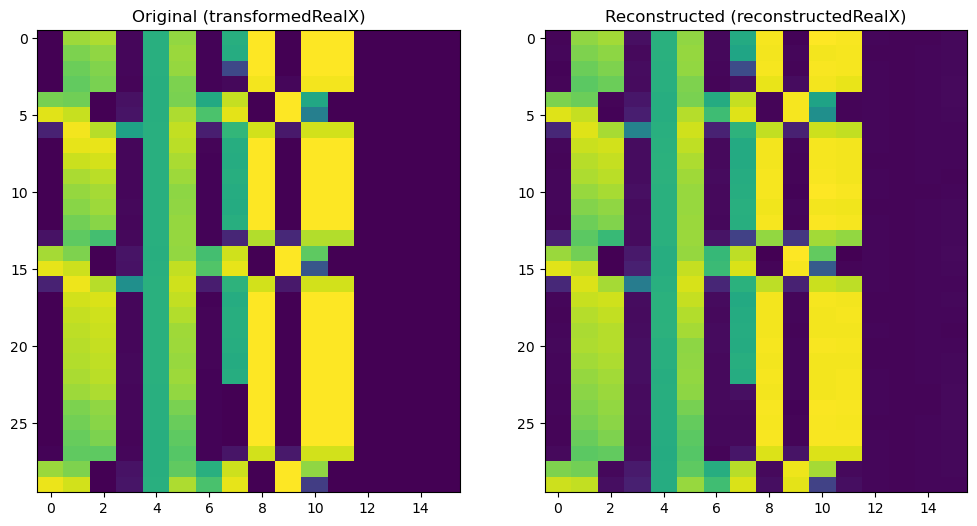

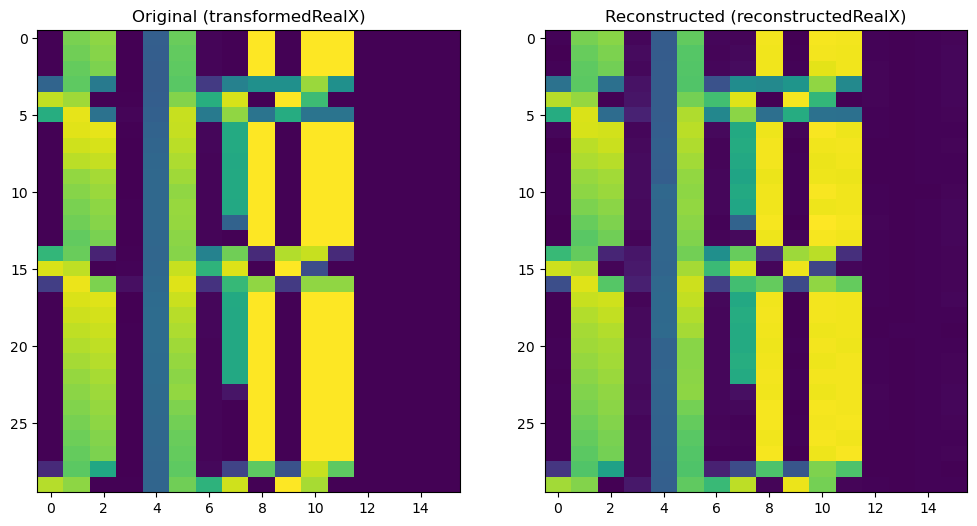

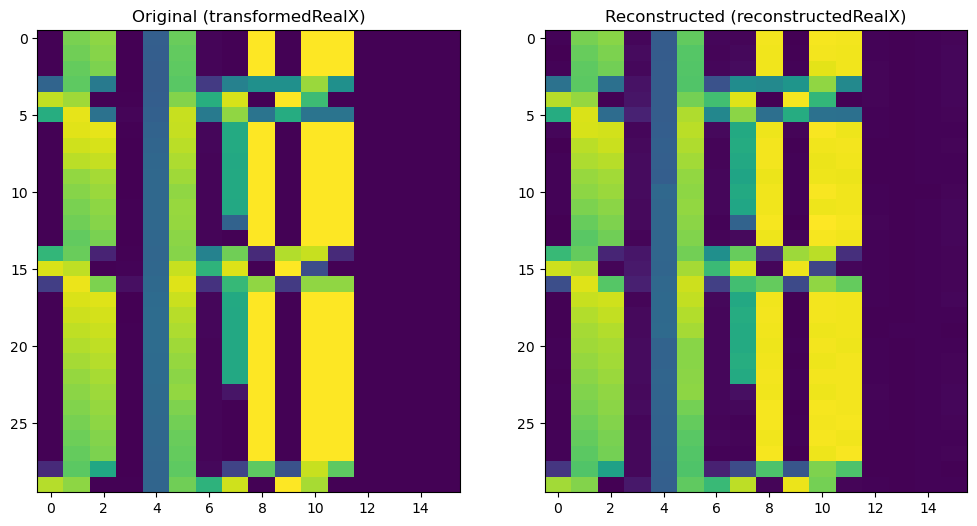

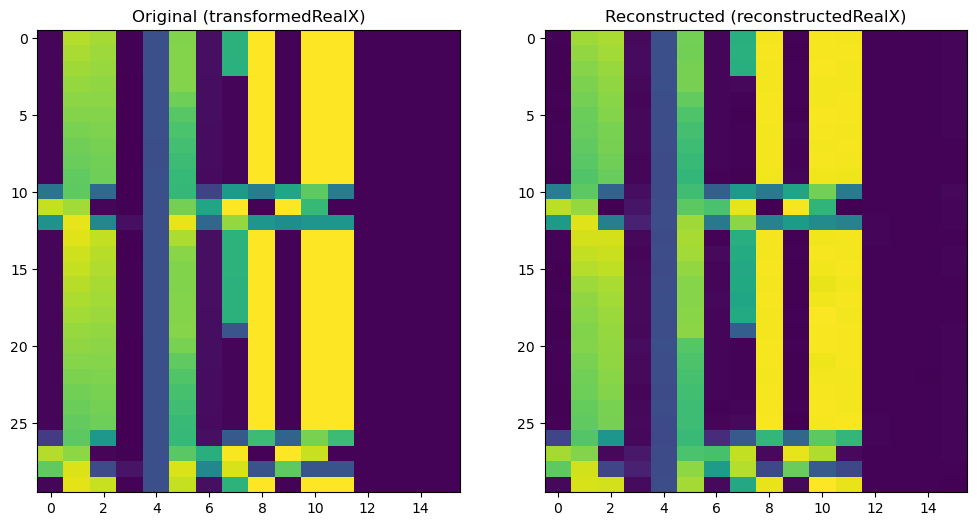

In [27]:
# Próbki do wizualizacji
sample_indexs = [0, -4753 // 2, 4753 // 2, 4753 - 1, ]

for sample_index in sample_indexs:
    # Upewnij się, że dane są w odpowiednim kształcie i mają ten sam rozmiar
    if transformedRealX.shape == reconstructedRealX.shape:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(transformedRealX[sample_index], aspect='auto', cmap='viridis')
        axes[0].set_title('Original (transformedRealX)')
        axes[1].imshow(reconstructedRealX[sample_index], aspect='auto', cmap='viridis')
        axes[1].set_title('Reconstructed (reconstructedRealX)')
        plt.show()
    else:
        print("Kształty danych nie są zgodne, nie można zwizualizować.")


## test classifier model

In [28]:
recerr = (reconstructedRealX - transformedRealX)

recerr_agg = np.mean(np.mean(np.abs(recerr), axis=1), axis=1)
recerr_agg_idx = np.argmax(np.mean(np.abs(recerr), axis=1), axis=1)

recerr_agg_df = pd.DataFrame({'timestamp': timestamps, 'erro': recerr_agg})
recerr_agg_df['err'] = recerr_agg_df['erro']
recerr_agg_df['err'] = exponential_smoothing(recerr_agg_df['erro'], alpha=0.5)

rolling_buffer = '7d'

err = recerr_agg_df.set_index('timestamp')
# err.loc[:, "threshold_err"] = (err.rolling(rolling_buffer).mean() + 3 * err.rolling(rolling_buffer).std())['err']
# err['alert'] = (err['err'] > err['threshold_err']).astype(int)  #/2
err_2 = calculate_threshold_err_cumalert(err)

err_2.describe()

,erro,err,threshold_err,alert,cumalert
count,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000
mean,0.010257,0.010256,0.012092,1.329687,0.543446
std,0.011977,0.011020,0.003578,7.171486,1.566785
min,0.003431,0.004268,0.000000,0.000000,0.000000
25%,0.007088,0.007323,0.011606,0.000000,0.000000
50%,0.009193,0.009240,0.012842,0.000000,0.000000
75%,0.010817,0.010849,0.014194,0.000000,0.000000
max,0.255129,0.231513,0.015416,40.000000,8.000000


(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

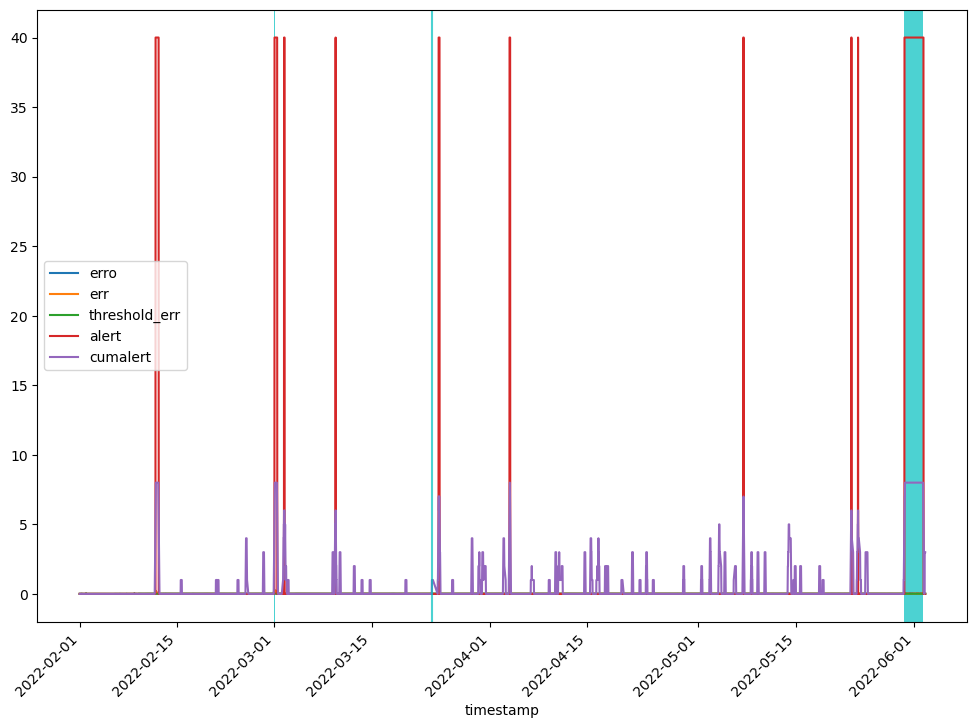

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

err_2.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00', '2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation=45)

In [29]:
erri = err_2.reset_index()
Xerr = erri[erri['alert'] > 0]
Xset = erri[erri['cumalert'] == 0].sample(len(Xerr))

dsidxerr = list(Xerr.index)
dsixnormal = list(Xset.index)

cl_inputX = np.concatenate((transformedRealX[dsidxerr, :, :], transformedRealX[dsixnormal, :, :]))
cl_inputy = to_categorical(np.concatenate((np.ones(len(Xerr)), np.zeros(len(Xset)))))

fXtrain, fXtest, ftrainy, ftesty = train_test_split(cl_inputX, cl_inputy, shuffle=False)

predicted = model_classifier.predict(fXtrain)
print(len(predicted), type(predicted))

pd.DataFrame(predicted).describe()

2024-03-08 12:52:15.042127: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5/Softmax' id:4417 op device:{requested: '', assigned: ''} def:{{{node dense_5/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


237 <class 'numpy.ndarray'>


2024-03-08 12:52:15.278630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


,0,1
count,2.370000e+02,2.370000e+02
mean,2.355700e-01,7.644300e-01
std,4.027233e-01,4.027233e-01
min,0.000000e+00,4.266590e-07
25%,4.578143e-08,8.010852e-01
50%,5.326044e-05,9.999467e-01
75%,1.989149e-01,1.000000e+00
max,9.999995e-01,1.000000e+00


In [30]:
print('f1_score', f1_score(np.argmax(ftrainy, axis=1), np.argmax(predicted, axis=1)))
pd.DataFrame(ftrainy[100:110]).head()

f1_score 0.9349112426035503


,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


# SHAP

In [33]:
# TODO use this background for SHAP
bg_size: int = 25  # num of windows
np.random.seed(202442)  # Set the seed for reproducibility
indexes = np.arange(len(fXtrain))
np.random.shuffle(indexes)  # Shuffle the indexes
maxid = min(bg_size, len(fXtrain))  # Determine the maximum index
_background_data = fXtrain[indexes[:maxid]]  # Select the background data
print(_background_data.shape)

_flattened_background_data = _background_data.reshape(bg_size, -1)
_flattened_feature_names = [f'timestep_{i // 16}_feature_{i % 16}' for i in range(_flattened_background_data.shape[1])]
print(len(_flattened_feature_names))

(25, 30, 16)
480


In [37]:
sv_ts_absshap, sv_tr_absshap, shap_values_ts_absshap, shap_values_tr_absshap = (
    calculate_shap_values(
        fXtrain, fXtest, ftrainy, ftesty, model_classifier,
        stride, window_len, shap_version='deep',
        bg_size=1000, absshap=True, background_data=_background_data))

In [38]:
print("test - shap values col1", np.array(sv_ts_absshap).shape)
print("train - shap values col1", np.array(sv_tr_absshap).shape)
print("test - shap values col1+2", np.array(shap_values_ts_absshap).shape)
print("test - shap values col1+2", np.array(shap_values_tr_absshap).shape)

test - shap values col1 (79, 30, 16)
train - shap values col1 (237, 30, 16)
test - shap values col1+2 (2, 79, 30, 16)
test - shap values col1+2 (2, 237, 30, 16)


In [39]:
sv_ts_no_absshap, sv_tr_no_absshap, shap_values_ts_no_absshap, shap_values_tr_no_absshap = calculate_shap_values(
    fXtrain, fXtest, ftrainy, ftesty, model_classifier,
    stride, window_len, shap_version='deep',
    bg_size=1000, absshap=False, background_data=_background_data)

In [40]:
save_to_pickle(sv_ts_absshap, 'sv_ts_absshap_same_bckgr.pkl')
save_to_pickle(sv_tr_absshap, 'sv_tr_absshap_same_bckgr.pkl')
save_to_pickle(shap_values_ts_absshap, 'shap_values_ts_absshap_same_bckgr.pkl')
save_to_pickle(shap_values_tr_absshap, 'shap_values_tr_absshap_same_bckgr.pkl')

save_to_pickle(sv_ts_no_absshap, 'sv_ts_no_absshap_same_bckgr.pkl')
save_to_pickle(sv_tr_no_absshap, 'sv_tr_no_absshap_same_bckgr.pkl')
save_to_pickle(shap_values_ts_no_absshap, 'shap_values_ts_no_absshap_same_bckgr.pkl')
save_to_pickle(shap_values_tr_no_absshap, 'shap_values_tr_no_absshap_same_bckgr.pkl')

Saved to shared/metropt/sv_ts_absshap_same_bckgr.pkl
Saved to shared/metropt/sv_tr_absshap_same_bckgr.pkl
Saved to shared/metropt/shap_values_ts_absshap_same_bckgr.pkl
Saved to shared/metropt/shap_values_tr_absshap_same_bckgr.pkl
Saved to shared/metropt/sv_ts_no_absshap_same_bckgr.pkl
Saved to shared/metropt/sv_tr_no_absshap_same_bckgr.pkl
Saved to shared/metropt/shap_values_ts_no_absshap_same_bckgr.pkl
Saved to shared/metropt/shap_values_tr_no_absshap_same_bckgr.pkl


In [31]:
#### new, OK ####
sv_ts_absshap = load_from_pickle("sv_ts_absshap_same_bckgr.pkl", directory=DATA_DIRECTORY)
sv_tr_absshap = load_from_pickle("sv_tr_absshap_same_bckgr.pkl", directory=DATA_DIRECTORY)

sv_ts_no_absshap = load_from_pickle("sv_ts_no_absshap_same_bckgr.pkl", directory=DATA_DIRECTORY)
sv_tr_no_absshap = load_from_pickle("sv_tr_no_absshap_same_bckgr.pkl", directory=DATA_DIRECTORY)

#### old ####
# shap_values_ts_v9_seq = load_from_pickle("shap_values_ts_v9_seq.pkl", directory=DATA_DIRECTORY)
# shap_values_tr_v9_seq = load_from_pickle("shap_values_tr_v9_seq.pkl", directory=DATA_DIRECTORY)
# sv_ts_v9_seq = load_from_pickle("sv_ts_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY)
sv_tr_v9_seq = load_from_pickle("sv_tr_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY)
# 
# print("sv_ts_absshap shape:", sv_ts_absshap.shape)
# print("sv_tr_absshap shape:", sv_tr_absshap.shape)
# print("sv_ts_v9_seq shape:", sv_ts_v9_seq.shape)  # tylko dla train - don't use
# print("sv_tr_v9_seq shape:", sv_ts_v9_seq.shape)

In [42]:
difference = np.abs(sv_tr_absshap - sv_tr_v9_seq)
total_difference = np.sum(difference)
print("Całkowita różnica:", total_difference)

mse = mean_squared_error(sv_tr_absshap.reshape(-1), sv_tr_v9_seq.reshape(-1))
print("MSE:", mse)

max_difference = np.max(difference)
mean_difference = np.mean(difference)
print("Maksymalna różnica:", max_difference)
print("Średnia różnica:", mean_difference)

Całkowita różnica: 133.88820553918103
MSE: 1.4443273082720034e-05
Maksymalna różnica: 0.14631918004139738
Średnia różnica: 0.0011769357027002552


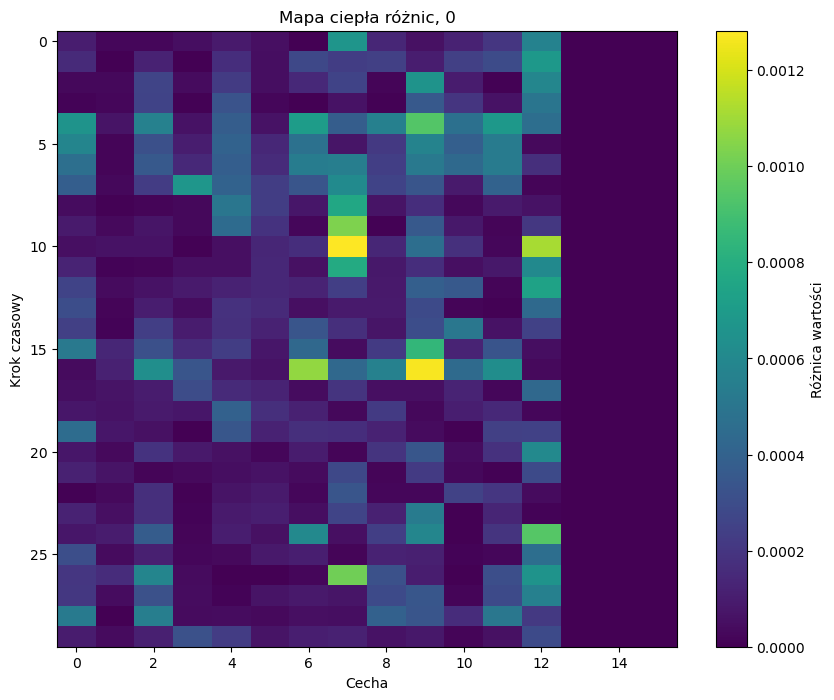

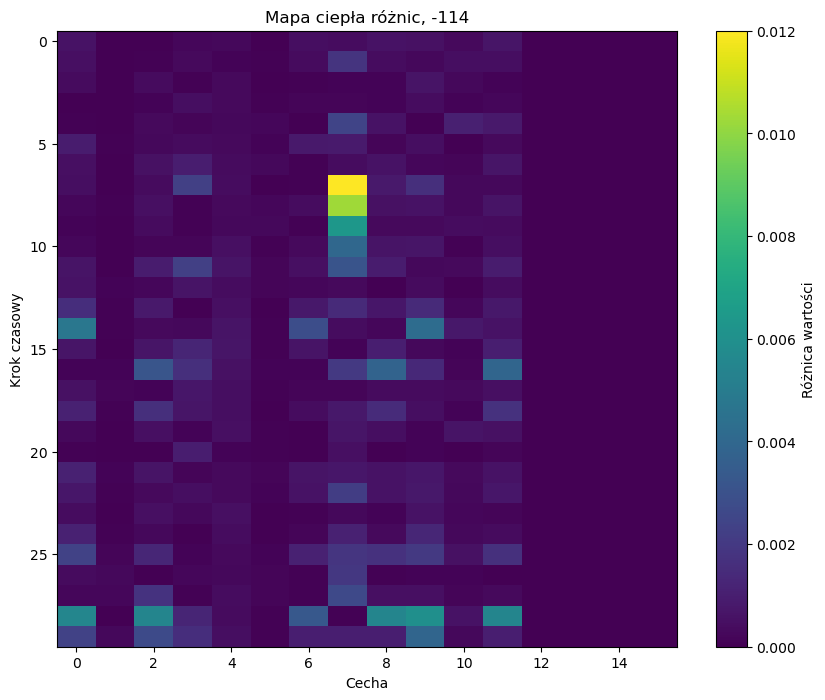

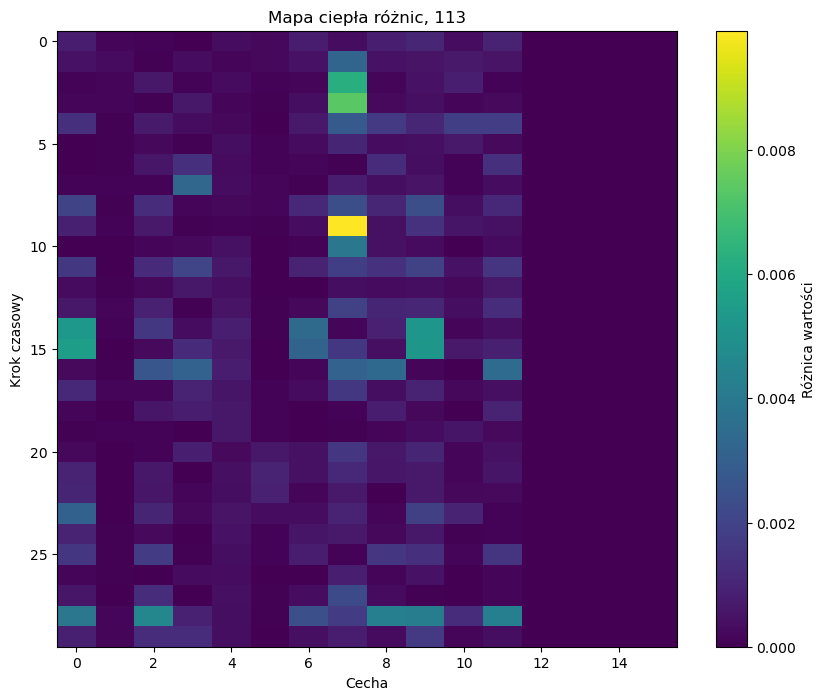

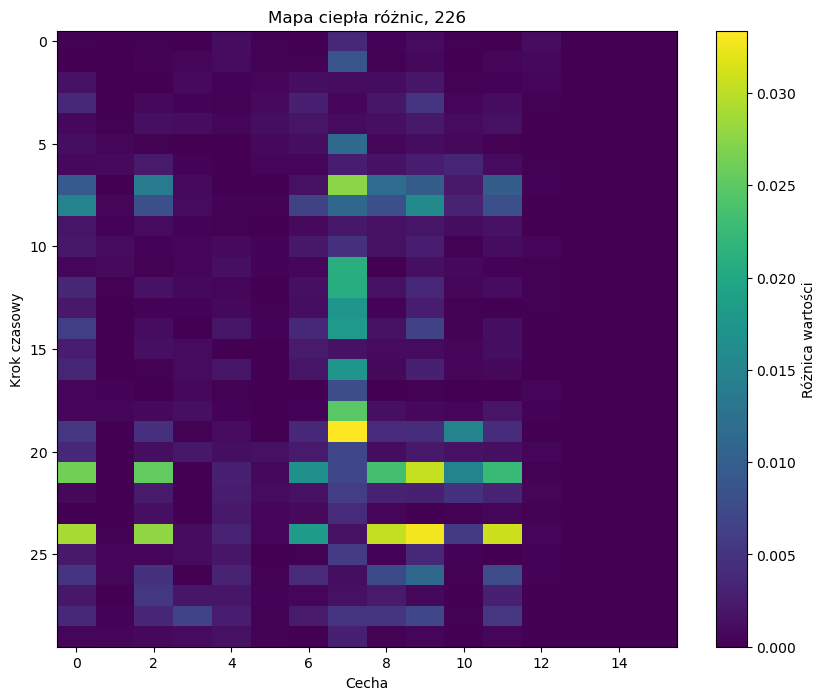

In [43]:
window_indexes = [s // 21 for s in sample_indexs]

for sample_index in window_indexes:
    # Oblicz różnicę dla wybranej próbki
    sample_difference = np.abs(sv_tr_absshap[sample_index] - sv_tr_v9_seq[sample_index])

    # Generuj mapę ciepła różnic
    plt.figure(figsize=(10, 8))
    plt.imshow(sample_difference, cmap='viridis', aspect='auto')
    plt.colorbar(label='Różnica wartości')
    plt.title(f'Mapa ciepła różnic, {sample_index}')
    plt.xlabel('Cecha')
    plt.ylabel('Krok czasowy')
    plt.show()

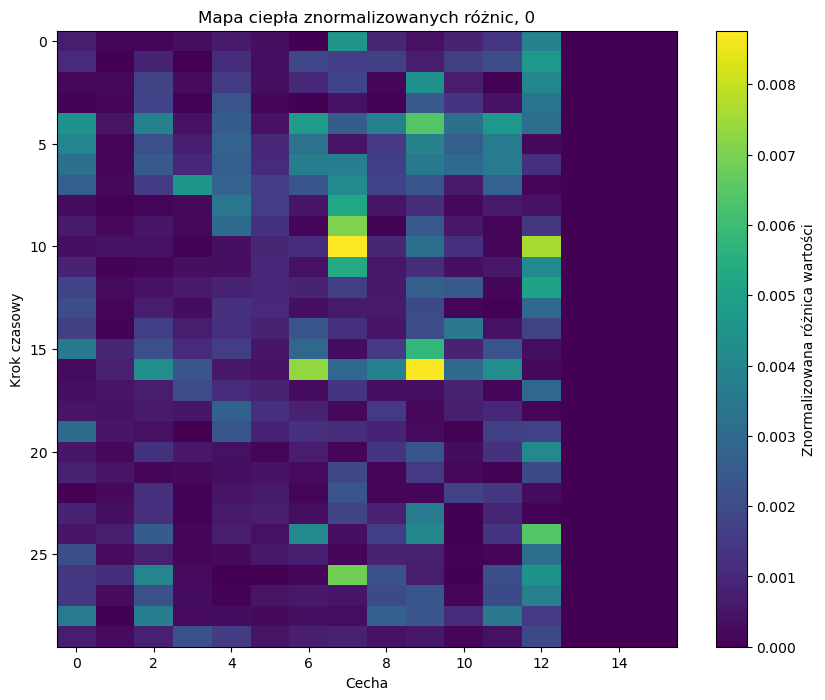

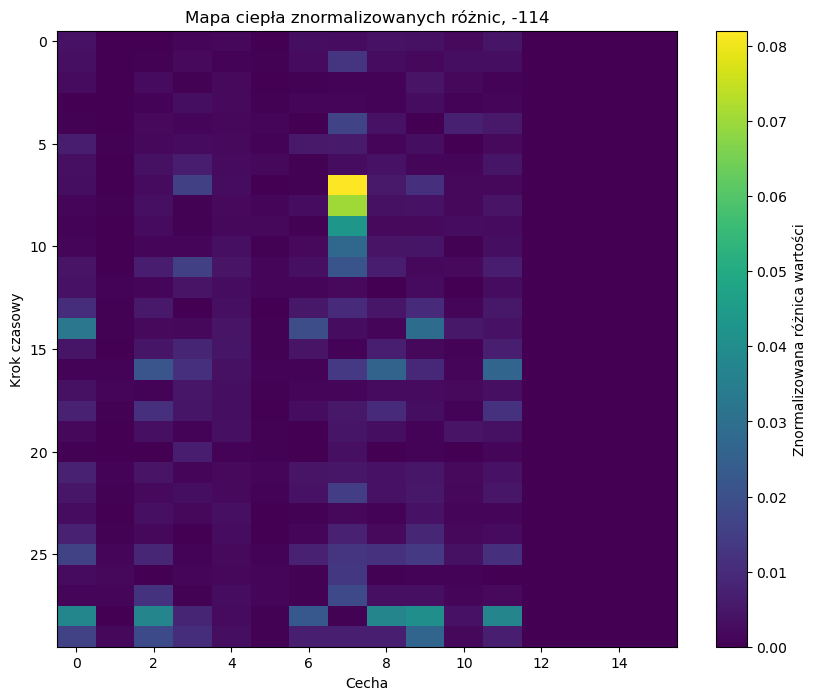

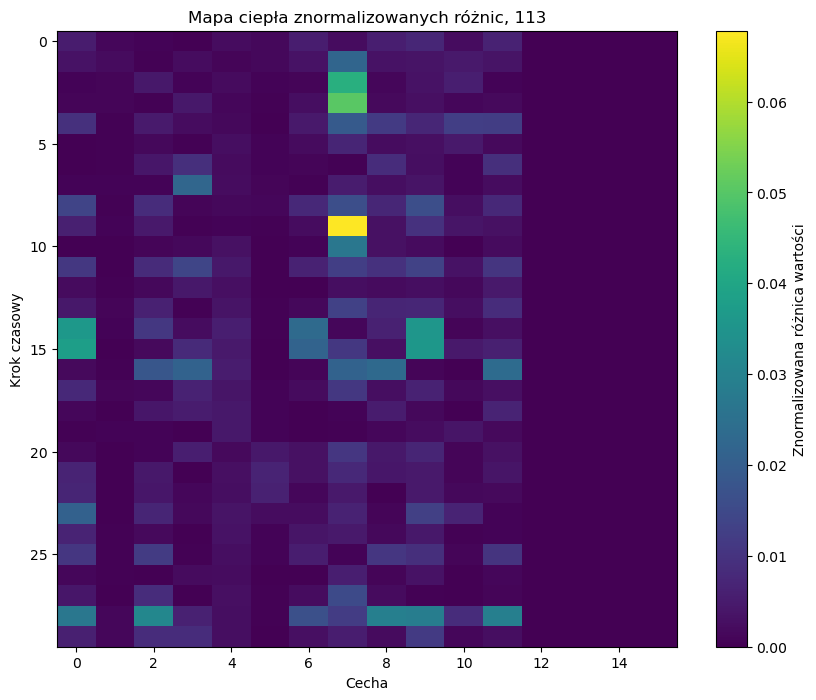

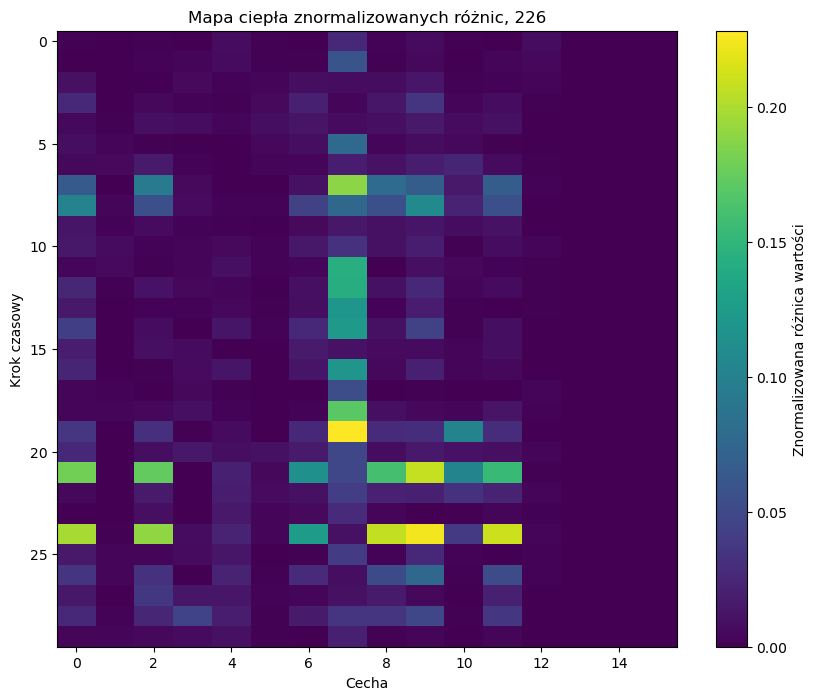

In [44]:
# Obliczanie różnicy między dwoma zestawami danych
difference = np.abs(sv_tr_absshap - sv_tr_v9_seq)

# Normalizacja różnic do zakresu [0, 1]
normalized_difference = (difference - np.min(difference)) / (np.max(difference) - np.min(difference))

# Wybór próbki do wizualizacji
for sample_index in window_indexes:
    # Tworzenie mapy ciepła dla znormalizowanej różnicy
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_difference[sample_index], cmap='viridis', aspect='auto')
    plt.colorbar(label='Znormalizowana różnica wartości')
    plt.title(f'Mapa ciepła znormalizowanych różnic, {sample_index}')
    plt.xlabel('Cecha')
    plt.ylabel('Krok czasowy')
    plt.show()

# Na podstawie paska kolorów obok mapy ciepła, można zauważyć, że wartości różnic znajdują się w bardzo wąskim zakresie, co sugeruje, że wszystkie znormalizowane różnice między danymi są stosunkowo małe i zbliżone do siebie. Wartości wydają się być z zakresie około -0.434 do -0.424, co jest bardzo niewielką zmiennością. To może wskazywać, że dane w obu zestawach są bardzo podobne do siebie i żadne z danych nie odstaje znacząco od reszty.

In [43]:
pd.DataFrame(sv_tr_absshap[0]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000151,0.000011,0.000221,0.000025,0.000088,0.000412,0.000173,0.002126,0.000734,0.000873,0.000517,0.000518,0.004624,0.0,0.0,0.000000e+00
1,0.000349,0.000006,0.000307,0.000059,0.000190,0.000550,0.000481,0.001127,0.000056,0.000475,0.000457,0.000030,0.003120,0.0,0.0,0.000000e+00
2,0.000059,0.000004,0.000218,0.000040,0.000328,0.000573,0.000092,0.000885,0.000677,0.000649,0.000554,0.000484,0.001984,0.0,0.0,0.000000e+00
3,0.000510,0.000012,0.000676,0.000015,0.000386,0.000607,0.000758,0.000564,0.001104,0.001303,0.000696,0.000939,0.001177,0.0,0.0,1.771413e-09
4,0.000785,0.000095,0.000613,0.000064,0.000577,0.000677,0.001202,0.000475,0.000982,0.001338,0.000648,0.001179,0.000485,0.0,0.0,0.000000e+00


In [44]:
pd.DataFrame(sv_tr_no_absshap[0]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.000151,-0.000011,0.000221,-0.000025,0.000088,0.000412,-0.000173,0.002126,0.000734,0.000873,0.000517,0.000518,0.004624,0.0,0.0,0.000000e+00
1,-0.000349,0.000006,-0.000307,-0.000059,0.000190,0.000550,-0.000481,0.001127,0.000056,-0.000475,0.000457,0.000030,0.003120,0.0,0.0,0.000000e+00
2,0.000059,-0.000004,0.000218,0.000040,0.000328,0.000573,0.000092,0.000885,0.000677,0.000649,0.000554,0.000484,0.001984,0.0,0.0,0.000000e+00
3,0.000510,0.000012,0.000676,-0.000015,0.000386,0.000607,0.000758,0.000564,0.001104,0.001303,0.000696,0.000939,0.001177,0.0,0.0,-1.771460e-09
4,0.000785,-0.000095,0.000613,-0.000064,0.000577,0.000677,0.001202,0.000475,0.000982,0.001338,0.000648,0.001179,0.000485,0.0,0.0,0.000000e+00


# LIME

In [45]:
pd.DataFrame(ftrainy).head()

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [50]:
print(type(fXtrain), type(ftrainy))  #, fXtest, ftrainy, ftesty
print(fXtrain.shape)
pd.DataFrame(ftesty).describe()
pd.DataFrame(ftrainy).describe()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(237, 30, 16)


,0,1
count,237.000000,237.000000
mean,0.333333,0.666667
std,0.472402,0.472402
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [47]:
model_wrapper = ModelWrapper(model_classifier, timesteps=30, features=16)


def fn_predict_class(x):
    preds = [np.argmax(pred) for pred in model_wrapper.predict_proba(x)]
    return preds


print(", ".join([str(x) for x in fn_predict_class(_flattened_background_data)]))

1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1


In [48]:
_class_names = ['class_0', 'class_1']

_feature_names = [f'feature_{i}' for i in range(_background_data.shape[2])]
print(_feature_names)
print(_flattened_feature_names[:35])

single_prediction = model_wrapper.predict_proba(_flattened_background_data[10])
print('single_prediction', single_prediction)

batch_prediction = model_wrapper.predict_proba(_flattened_background_data)
print('batch_prediction', batch_prediction[9:15])

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15']
['timestep_0_feature_0', 'timestep_0_feature_1', 'timestep_0_feature_2', 'timestep_0_feature_3', 'timestep_0_feature_4', 'timestep_0_feature_5', 'timestep_0_feature_6', 'timestep_0_feature_7', 'timestep_0_feature_8', 'timestep_0_feature_9', 'timestep_0_feature_10', 'timestep_0_feature_11', 'timestep_0_feature_12', 'timestep_0_feature_13', 'timestep_0_feature_14', 'timestep_0_feature_15', 'timestep_1_feature_0', 'timestep_1_feature_1', 'timestep_1_feature_2', 'timestep_1_feature_3', 'timestep_1_feature_4', 'timestep_1_feature_5', 'timestep_1_feature_6', 'timestep_1_feature_7', 'timestep_1_feature_8', 'timestep_1_feature_9', 'timestep_1_feature_10', 'timestep_1_feature_11', 'timestep_1_feature_12', 'timestep_1_feature_13', 'timestep_1_feature_14', 'timestep_1_feature_15', 'tim

In [51]:
_instance = fXtrain[0]
_flattened_instance = _instance.reshape(1, -1)[0]

In [57]:
lime_explainer = LimeTabularExplainer(_flattened_background_data,
                                      feature_names=_flattened_feature_names,
                                      class_names=_class_names,
                                      mode='classification')

explanation = lime_explainer.explain_instance(_flattened_instance, model_wrapper.predict_proba,
                                              num_features=len(_flattened_feature_names))
lime_importance = np.array([explanation.local_exp[1][i][1] for i in range(len(_flattened_feature_names))])
original_lime_importance = lime_importance.reshape((30, 16))
pd.DataFrame(original_lime_importance).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.001191,-0.001096,-0.001043,0.001021,-0.001005,-0.000918,-0.000908,-0.000905,-0.000903,0.000883,0.000847,-0.000842,0.000820,-0.000820,-0.000801,0.000774
1,-0.000768,0.000766,-0.000758,0.000756,-0.000734,0.000716,0.000711,0.000700,0.000669,-0.000668,-0.000666,-0.000663,-0.000659,-0.000639,-0.000627,-0.000620
2,-0.000612,0.000608,-0.000600,-0.000584,-0.000583,-0.000577,-0.000554,-0.000549,-0.000548,-0.000539,-0.000531,0.000531,-0.000528,0.000521,0.000512,0.000511
3,0.000506,0.000505,0.000487,-0.000482,0.000476,-0.000473,0.000472,0.000471,-0.000470,-0.000467,-0.000463,-0.000460,-0.000458,-0.000456,0.000445,-0.000433
4,-0.000429,0.000424,-0.000422,0.000422,-0.000421,-0.000416,0.000416,0.000399,-0.000395,0.000389,-0.000388,-0.000375,-0.000369,0.000355,-0.000350,0.000350


In [58]:
print(fXtrain[2:9, :, :].shape)

(7, 30, 16)


In [59]:
lime_explanation_fXtrain_2_9 = compute_lime_explanation(
    fXtrain[2:9, :, :], model_wrapper, lime_explainer,
    16, 30)  # 10 seconds

pd.DataFrame(lime_explanation_fXtrain_2_9[0]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.001072,-0.001061,-0.000999,0.000978,-0.000970,-0.000945,-0.000890,-0.000816,0.000813,0.000791,-0.000790,0.000789,-0.000784,-0.000784,0.000773,0.000759
1,-0.000759,0.000756,0.000755,-0.000718,-0.000709,-0.000700,0.000698,-0.000689,0.000684,-0.000678,0.000666,0.000658,-0.000649,-0.000646,-0.000632,-0.000603
2,-0.000600,-0.000596,-0.000587,-0.000572,-0.000557,-0.000547,-0.000547,-0.000545,-0.000532,-0.000525,-0.000523,0.000517,0.000512,-0.000505,-0.000504,-0.000491
3,0.000489,-0.000481,-0.000476,-0.000469,0.000468,-0.000462,0.000458,-0.000458,-0.000445,0.000441,0.000435,-0.000429,0.000428,0.000427,0.000426,-0.000421
4,-0.000410,0.000406,-0.000405,-0.000398,0.000385,-0.000385,-0.000383,-0.000376,-0.000372,0.000372,-0.000370,0.000369,-0.000364,-0.000364,0.000354,0.000354


In [ ]:
lime_explanation_fXtrain_2_9_parallel = compute_lime_explanation_parallel(
    fXtrain[2:9, :, :],
    seq_classifier_model_path, 16, 30,
    _flattened_background_data, _flattened_feature_names, _class_names,
    num_cores=2, gpu_idx=1)  # 30 seconds on CPU with 10 threads, 11 on 2 threads GPU

In [ ]:
pd.DataFrame(lime_explanation_fXtrain_2_9_parallel[0]).head()

In [0]:
lv_ts_no_absshap, lv_tr_no_absshap, lime_values_ts_no_absshap, lime_values_tr_no_absshap = calculate_explanations_values(
    fXtrain, fXtest, ftrainy, ftesty, model_classifier,
    explainer_type='LIME',
    background_data=_background_data, background_feature_names=_flattened_background_data,
    num_features=16, timesteps=30, class_names=_class_names, absshap=False, parallel=False)

In [185]:
print(lime_values_tr_no_absshap.shape)
print(sv_tr_no_absshap.shape)

(237, 30, 16)

In [193]:
# lv_ts_no_absshap, lv_tr_no_absshap = lime_values_ts_no_absshap, lime_values_tr_no_absshap

In [196]:
lv_ts_absshap, lv_tr_absshap, lime_values_ts_absshap, lime_values_tr_absshap = calculate_explanations_values(
    fXtrain, fXtest, ftrainy, ftesty, model_classifier,
    explainer_type='LIME',
    background_data=_background_data, background_feature_names=_flattened_background_data,
    num_features=16, timesteps=30, class_names=_class_names, absshap=True,
    explainer_raw_values_test=lime_values_ts_no_absshap,
    explainer_raw_values_train=lime_values_tr_no_absshap)

In [ ]:
pd.DataFrame(lv_ts_absshap[0]).head()

In [ ]:
pd.DataFrame(lv_ts_no_absshap[0]).head()

In [198]:
save_to_pickle(lv_ts_no_absshap, 'lv_ts_no_absshap.pkl')
save_to_pickle(lv_tr_no_absshap, 'lv_tr_no_absshap.pkl')
save_to_pickle(lime_values_ts_no_absshap, 'lime_values_ts_no_absshap.pkl')
save_to_pickle(lime_values_tr_no_absshap, 'lime_values_tr_no_absshap.pkl')

save_to_pickle(lv_ts_absshap, 'lv_ts_absshap.pkl')
save_to_pickle(lv_tr_absshap, 'lv_tr_absshap.pkl')
save_to_pickle(lime_values_ts_absshap, 'lime_values_ts_absshap.pkl')
save_to_pickle(lime_values_tr_absshap, 'lime_values_tr_absshap.pkl')

Saved to shared/metropt/lv_ts_no_absshap.pkl
Saved to shared/metropt/lv_tr_no_absshap.pkl
Saved to shared/metropt/lime_values_ts_no_absshap.pkl
Saved to shared/metropt/lime_values_tr_no_absshap.pkl
Saved to shared/metropt/lv_ts_absshap.pkl
Saved to shared/metropt/lv_tr_absshap.pkl
Saved to shared/metropt/lime_values_ts_absshap.pkl
Saved to shared/metropt/lime_values_tr_absshap.pkl


In [49]:
lv_ts_no_absshap = load_from_pickle('lv_ts_no_absshap.pkl')
lv_tr_no_absshap = load_from_pickle('lv_tr_no_absshap.pkl')

lv_ts_absshap = load_from_pickle('lv_ts_absshap.pkl')
lv_tr_absshap = load_from_pickle('lv_tr_absshap.pkl')

Total difference: 147.81152833408447
MSE: 1.3646551311545421e-05
Maximum difference: 0.15092796749388218
Mean difference: 0.0012993277807145259


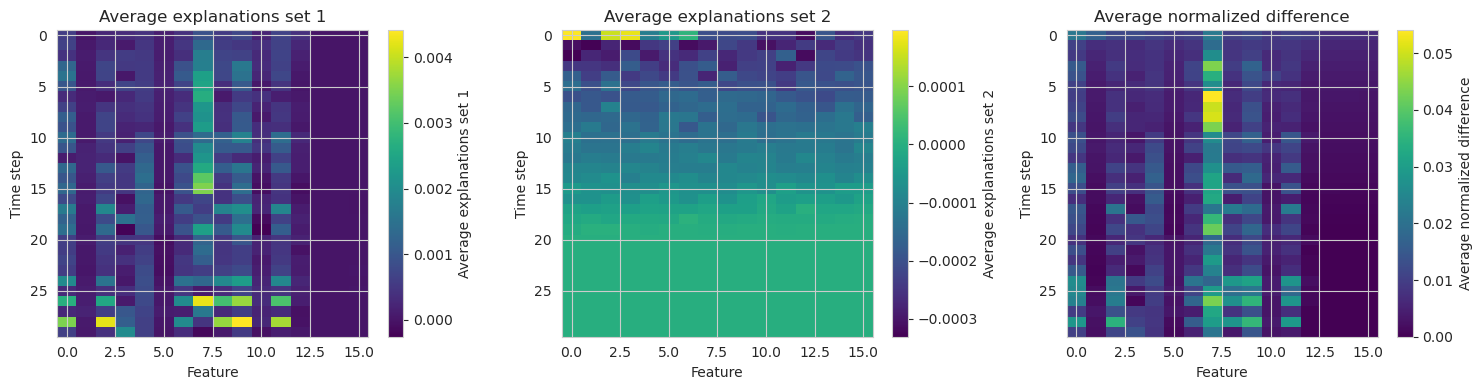

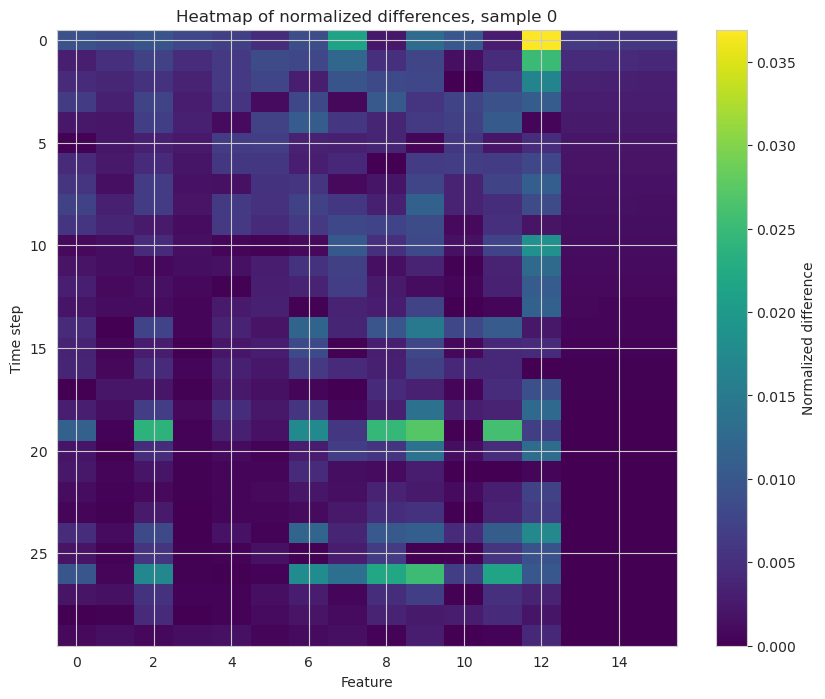

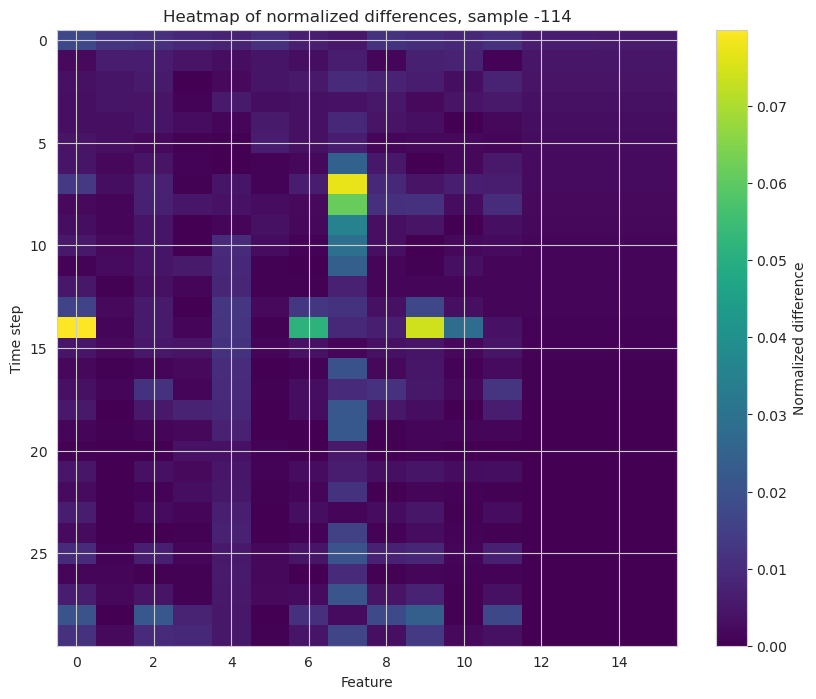

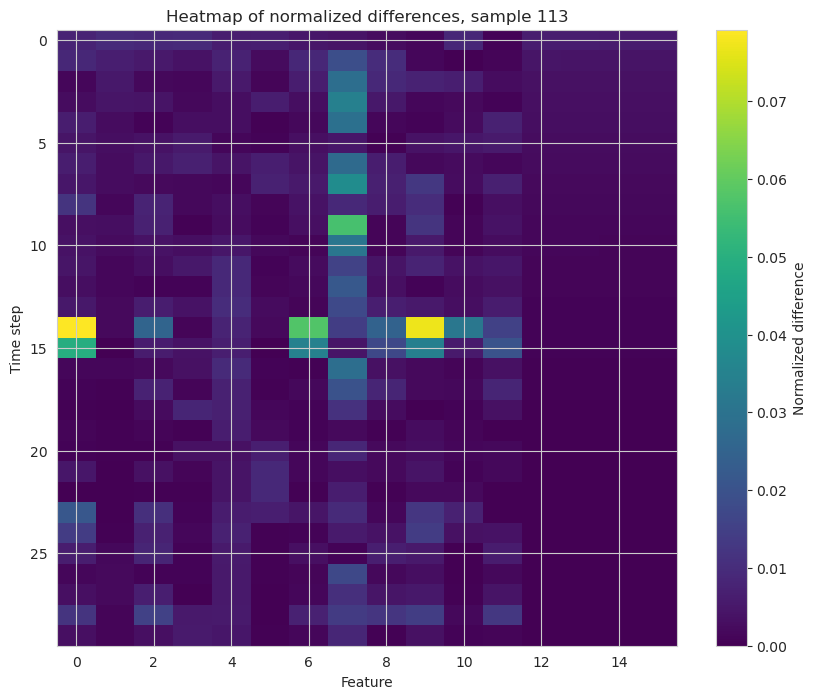

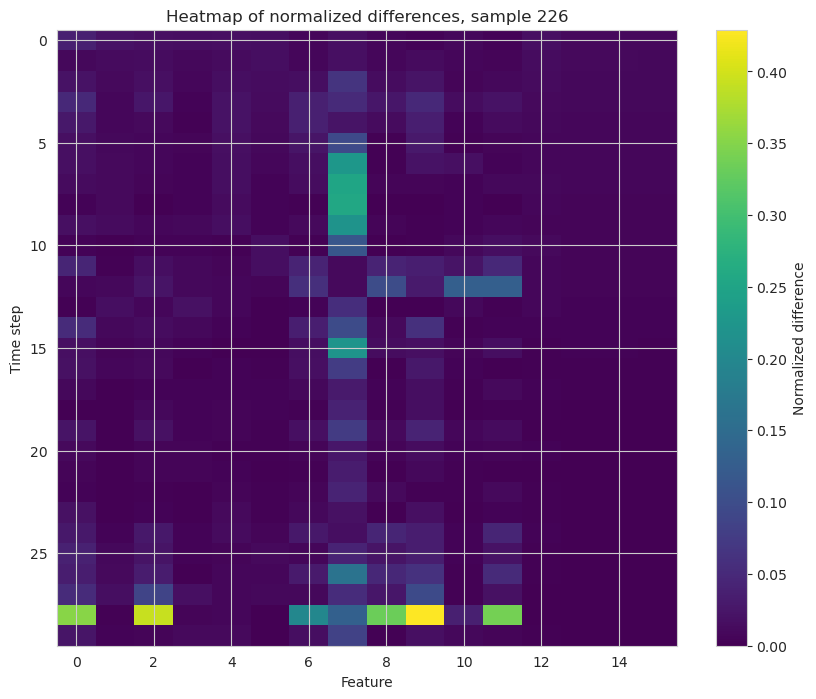

In [201]:
visualize_explanation_difference(sv_tr_no_absshap, lv_tr_no_absshap, window_indexes)

In [ ]:
compute_generic_explanation_parallel(
    fXtrain[2:9, :, :],
    seq_classifier_model_path, 16, 30,
    _flattened_background_data, _flattened_feature_names, _class_names,
    worker_init_lime, worker_init_model, compute_single_lime_explanation,
    num_cores=2, gpu_idx=1)  # no improvement

# ANCHOR

In [61]:
print(model_classifier.predict(fXtrain[30:32, :, :]))
print(model_wrapper.predict_proba(fXtrain[30:32, :, :]))
print(model_wrapper.predict_proba(_flattened_background_data[19:21]))
print(model_wrapper.predict_proba(_flattened_instance))

[[5.9220372e-03 9.9407792e-01]
 [4.1460121e-04 9.9958545e-01]]
[[5.9220372e-03 9.9407792e-01]
 [4.1460121e-04 9.9958545e-01]]
[[5.8341627e-08 1.0000000e+00]
 [3.5282378e-06 9.9999642e-01]]
[[0. 1.]]


In [65]:
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    train_data=_flattened_background_data,
    feature_names=_flattened_feature_names,
    class_names=[0, 1],  #_class_names - does not work
    # discretizer='quartile'
)

In [66]:
print(fn_predict_class(_flattened_background_data[19:21]))
print(fn_predict_class(fXtrain[2:3, :, :]))
print(fn_predict_class(_flattened_background_data))

[1, 1]
[1]
[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]


In [67]:
anchor_exp = anchor_explainer.explain_instance(
    _flattened_background_data[19:20],
    lambda x: [np.argmax(pred) for pred in model_wrapper.predict_proba(x)],
    threshold=0.95
)  # 1.5 min
anchor_exp

In [68]:
anchor_exp.coverage()
anchor_exp.precision()
anchor_exp.names()

['timestep_27_feature_7 > 0.71', 'timestep_16_feature_11 <= 0.57']

In [73]:
anchor_exp_2 = compute_single_anchor_explanation(-1, fXtrain[2:3, :, :], model_wrapper, anchor_explainer, 16, 30,
                                                 _flattened_feature_names)  # 2 min
print(anchor_exp_2)

(-1, [[{'rule': {'timestep_9_feature_7': ['>0.62'], 'timestep_16_feature_1': ['<=0.78'], 'timestep_16_feature_10': ['<=0.78']}, 'prediction': '1', 'confidence': 1.0}]])


In [74]:
anchor_explanation_fXtrain_2_9 = compute_anchor_explanation(
    fXtrain[2:9, :, :], model_wrapper, anchor_explainer,
    16, 30, _flattened_feature_names)  # 10 min
print(anchor_explanation_fXtrain_2_9)

new instances.shape (7, 480)
[[[{'rule': {'timestep_25_feature_1': ['>0.00'], 'timestep_25_feature_12': ['>0.00'], 'timestep_26_feature_7': ['>0.58']}, 'prediction': '1', 'confidence': 1.0}]]

 [[{'rule': {'timestep_13_feature_7': ['>0.63'], 'timestep_14_feature_4': ['>0.61']}, 'prediction': '1', 'confidence': 1.0}]]

 [[{'rule': {'timestep_0_feature_4': ['>0.62'], 'timestep_8_feature_7': ['>0.62']}, 'prediction': '1', 'confidence': 1.0}]]

 [[{'rule': {'timestep_12_feature_1': ['>0.00'], 'timestep_12_feature_12': ['>0.00'], 'timestep_24_feature_1': ['>0.00'], 'timestep_24_feature_12': ['>0.00']}, 'prediction': '1', 'confidence': 1.0}]]

 [[{'rule': {'timestep_26_feature_4': ['>0.61'], 'timestep_26_feature_7': ['>0.58']}, 'prediction': '1', 'confidence': 1.0}]]

 [[{'rule': {'timestep_6_feature_5': ['>0.86'], 'timestep_7_feature_7': ['>0.61']}, 'prediction': '1', 'confidence': 1.0}]]

 [[{'rule': {'timestep_17_feature_4': ['>0.60'], 'timestep_17_feature_6': ['<=0.23']}, 'prediction': '

In [ ]:
# anchor_explanation_fXtrain_2_9_parallel = compute_generic_explanation_parallel(
#     fXtrain[2:9, :, :],
#     seq_classifier_model_path, 16, 30,
#     _flattened_background_data, _flattened_feature_names, _class_names,
#     worker_init_anchor, worker_init_model, compute_single_anchor_explanation,
#     num_cores=2, gpu_idx=1)  # longer than 5 minutes
# print(anchor_explanation_fXtrain_2_9_parallel)

In [ ]:
def calculate_explanations_values(fXtrain: np.ndarray,
                                  fXtest: np.ndarray,
                                  ftrainy: np.ndarray,
                                  ftesty: np.ndarray,
                                  model_classifier: Any,
                                  explainer_type: str,
                                  background_data,
                                  background_feature_names: List[str],
                                  num_features: int,
                                  timesteps: int,
                                  class_names: List[str],
                                  absshap: bool = True,
                                  explainer_raw_values_test: Optional[np.ndarray] = None,
                                  explainer_raw_values_train: Optional[np.ndarray] = None,
                                  parallel: bool = False,
                                  ) -> Tuple[
    Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Calculates SHAP values for training and testing datasets using either DeepExplainer or SlidingWindowSHAP.
    
    :param fXtrain: Training features.
    :param fXtest: Testing features.
    :param ftrainy: Training labels.
    :param ftesty: Testing labels.
    :param model_classifier: The model to explain.
    :param explainer_type: 
    :param background_data: 
    :param num_features: .
    :param timesteps: .
    :param class_names: .
    :param absshap: Whether to use absolute SHAP values, only for DeepExplainer.
    :param explainer_raw_values_test: .
    :param explainer_raw_values_train: .
    :param parallel: .
    :return: Tuple of SHAP values for training and testing datasets.
    """
    ev_test, ev_train = None, None

    if explainer_type == 'DEEP-SHAP':
        if explainer_raw_values_train is None and explainer_raw_values_test is None:
            explainer = shap.DeepExplainer(model_classifier, background_data)
            print(f"{explainer_type} - test DONE")
            explainer_raw_values_test = explainer.shap_values(fXtest, check_additivity=False)
            print(f"{explainer_type} - train DONE")
            explainer_raw_values_train = explainer.shap_values(fXtrain, check_additivity=False)

        if absshap:
            ev_test = abs(np.array(explainer_raw_values_test)).mean(axis=0)
            ev_train = abs(np.array(explainer_raw_values_train)).mean(axis=0)
        else:
            try:
                indexer_ts = np.argmax(model_classifier.predict(fXtest), axis=1)
                ev_test = [explainer_raw_values_test[indexer_ts[i]][i, :] for i in range(len(fXtest))]
                ev_test = np.concatenate(ev_test).reshape((-1, timesteps, num_features))
            except Exception as e:
                print(f"! {e}")
                traceback.print_exc()

            try:
                indexer_tr = np.argmax(model_classifier.predict(fXtrain), axis=1)
                ev_train = [explainer_raw_values_train[indexer_tr[i]][i, :] for i in range(len(fXtrain))]
                ev_train = np.concatenate(ev_train).reshape((-1, timesteps, num_features))
            except Exception as e:
                print(f"! {e}")
                traceback.print_exc()

    elif explainer_type == 'LIME':
        if explainer_raw_values_train is None and explainer_raw_values_test is None:
            model_wrapper = ModelWrapper(model_classifier, timesteps=timesteps, features=num_features)

            flattened_background_data = background_data.reshape(bg_size, -1)
            # flattened_feature_names = [
            #     f'timestep_{i // num_features}_feature_{i % num_features}'
            #     for i in range(flattened_background_data.shape[1])]
            explainer = LimeTabularExplainer(
                flattened_background_data,
                feature_names=background_feature_names,
                class_names=class_names,
                mode='classification')
            explainer_raw_values_test = compute_lime_explanation(
                fXtest, model_wrapper, explainer,
                num_features, timesteps)
            print(f"{explainer_type} - test DONE")
            explainer_raw_values_train = compute_lime_explanation(
                fXtrain, model_wrapper, explainer,
                num_features, timesteps)
            print(f"{explainer_type} - train DONE")
            # TODO parallel=True
        if absshap:
            ev_test = np.abs(explainer_raw_values_test)
            ev_train = np.abs(explainer_raw_values_train)
        else:
            ev_test = explainer_raw_values_test
            ev_train = explainer_raw_values_train

    elif explainer_type == 'ANCHOR':
        if explainer_raw_values_train is None and explainer_raw_values_test is None:
            model_wrapper = ModelWrapper(model_classifier, timesteps=timesteps, features=num_features)

            flattened_background_data = background_data.reshape(bg_size, -1)
            # flattened_feature_names = [
            #     f'timestep_{i // num_features}_feature_{i % num_features}'
            #     for i in range(flattened_background_data.shape[1])]
            explainer = anchor_tabular.AnchorTabularExplainer(
                train_data=flattened_background_data,
                feature_names=background_feature_names,
                class_names=[0, 1],  #discretizer='quartile',
            )
            ev_test = compute_anchor_explanation(
                fXtest, model_wrapper, explainer,
                num_features, timesteps, background_feature_names)
            print(f"{explainer_type} - test DONE")
            ev_train = compute_anchor_explanation(
                fXtrain, model_wrapper, explainer,
                num_features, timesteps, background_feature_names)
            print(f"{explainer_type} - train DONE")

    return ev_test, ev_train, explainer_raw_values_test, explainer_raw_values_train



In [ ]:
av_ts, av_tr, _, _ = calculate_explanations_values(
    fXtrain, fXtest, ftrainy, ftesty, model_classifier,
    explainer_type='ANCHOR',
    background_data=_background_data, background_feature_names=_flattened_feature_names,
    num_features=16, timesteps=30, class_names=_class_names, absshap=False, parallel=False)

save_to_pickle(av_ts, "av_ts.pkl")
save_to_pickle(av_tr, "av_tr.pkl")

new instances.shape (79, 480)


 42%|████▏     | 33/79 [2:33:13<3:13:39, 252.60s/it]

# LUX

In [100]:
_flattened_instance_df = pd.DataFrame(
    _flattened_instance.reshape(1, -1), columns=_flattened_feature_names)
_flattened_background_data_df = pd.DataFrame(
    _flattened_background_data, columns=_flattened_feature_names)

lux_obj = LUX(predict_proba=lambda x: model_wrapper.predict_proba(x.values),
              neighborhood_size=0.1,
              max_depth=3,
              node_size_limit=4,
              grow_confidence_threshold=0,
              min_samples=50)

In [101]:
lux_obj.fit(_flattened_background_data_df,
            fn_predict_class(_flattened_background_data),
            instance_to_explain=_flattened_instance_df,
            inverse_sampling=True,
            oversampling=False, prune=True, oblique=False)

In [103]:
# @formatter:off
!cd lux/\lux && \
    if grep -q 'from pyuid3.data import Data' lux.py && grep -q 'from pyuid3.uid3 import UId3' lux.py && grep -q 'from pyuid3.entropy_evaluator import \*' lux.py; then \
    sed -i 's/from pyuid3.data import Data/from ..pyuid3.pyuid3.data import Data/' lux.py && \
    sed -i 's/from pyuid3.uid3 import UId3/from ..pyuid3.pyuid3.uid3 import UId3/' lux.py && \
    sed -i 's/from pyuid3.entropy_evaluator import \*/from ..pyuid3.pyuid3.entropy_evaluator import */' lux.py; \
    else echo "Possible that the imports are already modified"; fi
# @formatter:on

Possible that the imports are already modified


In [102]:
lux_rules = lux_obj.justify(_flattened_instance_df, to_dict=True)

AttributeError: 'LUX' object has no attribute 'uid3'